# Phase 2: 基础实验

> **目标**: 验证Random Forest模型在Modbus异常检测任务上的基本有效性
> 
> **执行时间**: 2026年1月
> 
> **实验内容**:
> - E1: 二分类异常检测（主要结果）
> - E2: 5-fold交叉验证（增强可靠性）

---

## 0. 环境准备

In [1]:
# 导入必要库
import os
import sys
import json
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# 添加项目路径 (使用绝对路径确保可靠性)
PROJECT_ROOT = Path(r"c:\Users\Echo\Desktop\modbus-detection")
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# 验证路径
print(f"项目根目录: {PROJECT_ROOT}")
print(f"src目录存在: {(PROJECT_ROOT / 'src').exists()}")
print(f"config.py存在: {(PROJECT_ROOT / 'src' / 'config.py').exists()}")

from config import (
    DATA_SPLITS, MODELS_DIR, FIGURES_DIR, TABLES_DIR,
    RANDOM_SEED, ensure_dirs
)
from feature_extractor import get_feature_names, get_feature_groups

# 设置
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# 确保目录存在
ensure_dirs()

# 随机种子
np.random.seed(RANDOM_SEED)

print("="*60)
print("Phase 2: 基础实验")
print("="*60)
print(f"\n执行时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"随机种子: {RANDOM_SEED}")

项目根目录: c:\Users\Echo\Desktop\modbus-detection
src目录存在: True
config.py存在: True
✓ 所有目录已创建
Phase 2: 基础实验

执行时间: 2026-01-14 10:03:20
随机种子: 42


## 1. 数据加载

In [2]:
# 加载训练/验证/测试集
print("加载数据集...")

df_train = pd.read_parquet(DATA_SPLITS / 'train.parquet')
df_val = pd.read_parquet(DATA_SPLITS / 'val.parquet')
df_test = pd.read_parquet(DATA_SPLITS / 'test.parquet')

print(f"\n数据集大小:")
print(f"  训练集: {len(df_train):,} 样本")
print(f"  验证集: {len(df_val):,} 样本")
print(f"  测试集: {len(df_test):,} 样本")
print(f"  总计:   {len(df_train) + len(df_val) + len(df_test):,} 样本")

加载数据集...

数据集大小:
  训练集: 83,078 样本
  验证集: 15,371 样本
  测试集: 19,760 样本
  总计:   118,209 样本


In [3]:
# 获取特征名
feature_names = get_feature_names()
print(f"\n特征数量: {len(feature_names)}")

# 分离特征和标签
X_train = df_train[feature_names].values
y_train = df_train['label'].values

X_val = df_val[feature_names].values
y_val = df_val['label'].values

X_test = df_test[feature_names].values
y_test = df_test['label'].values

print(f"\n特征矩阵形状:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


特征数量: 44

特征矩阵形状:
  X_train: (83078, 44)
  X_val:   (15371, 44)
  X_test:  (19760, 44)


In [4]:
# 标签分布
def print_label_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{name}:")
    for label, count in zip(unique, counts):
        print(f"  {label}: {count:,} ({count/len(y)*100:.2f}%)")

print_label_distribution(y_train, "训练集标签分布")
print_label_distribution(y_val, "验证集标签分布")
print_label_distribution(y_test, "测试集标签分布")

# 显示标签类型
print(f"\n标签类型: {type(y_train[0])}")
print(f"标签值: {np.unique(y_train)}")


训练集标签分布:
  Attack: 3,346 (4.03%)
  Normal: 79,732 (95.97%)

验证集标签分布:
  Attack: 760 (4.94%)
  Normal: 14,611 (95.06%)

测试集标签分布:
  Attack: 1,112 (5.63%)
  Normal: 18,648 (94.37%)

标签类型: <class 'str'>
标签值: ['Attack' 'Normal']


In [5]:
# 检查数据完整性
print("\n数据完整性检查:")

# 检查缺失值
train_missing = np.isnan(X_train).sum()
val_missing = np.isnan(X_val).sum()
test_missing = np.isnan(X_test).sum()

print(f"  训练集缺失值: {train_missing}")
print(f"  验证集缺失值: {val_missing}")
print(f"  测试集缺失值: {test_missing}")

# 检查无穷值
train_inf = np.isinf(X_train).sum()
val_inf = np.isinf(X_val).sum()
test_inf = np.isinf(X_test).sum()

print(f"  训练集无穷值: {train_inf}")
print(f"  验证集无穷值: {val_inf}")
print(f"  测试集无穷值: {test_inf}")

if train_missing + val_missing + test_missing + train_inf + val_inf + test_inf == 0:
    print("\n✓ 数据完整性检查通过")
else:
    print("\n⚠ 数据存在缺失值或无穷值，需要处理")


数据完整性检查:
  训练集缺失值: 0
  验证集缺失值: 0
  测试集缺失值: 0
  训练集无穷值: 0
  验证集无穷值: 0
  测试集无穷值: 0

✓ 数据完整性检查通过


## 2. Random Forest 主模型训练 (E1)

In [6]:
# 定义模型参数（与设计文档5.3节一致）
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': None,  # 让树充分生长（设计文档建议）
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'class_weight': 'balanced',  # 处理类别不平衡
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'oob_score': True  # 记录OOB分数
}

print("Random Forest 参数配置:")
for k, v in RF_PARAMS.items():
    print(f"  {k}: {v}")

Random Forest 参数配置:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  random_state: 42
  n_jobs: -1
  oob_score: True


In [7]:
# 训练模型
print("\n" + "="*60)
print("训练 Random Forest 模型...")
print("="*60)

rf_model = RandomForestClassifier(**RF_PARAMS)

train_start = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - train_start

print(f"\n训练完成!")
print(f"  训练时间: {train_time:.2f} 秒")
print(f"  OOB Score: {rf_model.oob_score_:.4f}")


训练 Random Forest 模型...

训练完成!
  训练时间: 3.68 秒
  OOB Score: 0.9960


## 3. 测试集评估

In [8]:
# 在测试集上预测
print("在测试集上评估...")

# 预测
inference_start = time.time()
y_pred = rf_model.predict(X_test)
inference_time = time.time() - inference_start

# 预测概率
y_pred_proba = rf_model.predict_proba(X_test)[:, 0]  # Attack类概率(classes_按字母序: Attack=0, Normal=1)

# 推理时间统计
inference_time_per_sample = inference_time / len(X_test) * 1000  # ms

print(f"\n推理性能:")
print(f"  总推理时间: {inference_time:.4f} 秒")
print(f"  每样本推理时间: {inference_time_per_sample:.4f} ms")
print(f"  目标: < 10 ms/样本 → {'✓ 达标' if inference_time_per_sample < 10 else '✗ 未达标'}")

在测试集上评估...

推理性能:
  总推理时间: 0.0845 秒
  每样本推理时间: 0.0043 ms
  目标: < 10 ms/样本 → ✓ 达标


In [9]:
# 计算评估指标
def calculate_metrics(y_true, y_pred, y_pred_proba):
    """计算所有评估指标"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label='Attack'),
        'recall': recall_score(y_true, y_pred, pos_label='Attack'),
        'f1': f1_score(y_true, y_pred, pos_label='Attack'),
        'auc_roc': roc_auc_score((y_true == 'Attack').astype(int), y_pred_proba),
        'auc_pr': average_precision_score((y_true == 'Attack').astype(int), y_pred_proba)
    }
    return metrics

test_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)

print("\n" + "="*60)
print("测试集性能指标 (Attack类)")
print("="*60)
print(f"\n  Accuracy:  {test_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {test_metrics['precision']*100:.2f}%")
print(f"  Recall:    {test_metrics['recall']*100:.2f}%  ← 重点关注")
print(f"  F1-Score:  {test_metrics['f1']*100:.2f}%")
print(f"  AUC-ROC:   {test_metrics['auc_roc']:.4f}")
print(f"  AUC-PR:    {test_metrics['auc_pr']:.4f}  ← 不平衡数据关键指标")

# 检查是否达到预期
print("\n预期目标检查:")
print(f"  Accuracy > 95%: {'✓' if test_metrics['accuracy'] > 0.95 else '✗'} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  F1-Score > 90%: {'✓' if test_metrics['f1'] > 0.90 else '✗'} ({test_metrics['f1']*100:.2f}%)")


测试集性能指标 (Attack类)

  Accuracy:  99.07%
  Precision: 94.96%
  Recall:    88.13%  ← 重点关注
  F1-Score:  91.42%
  AUC-ROC:   0.9991
  AUC-PR:    0.9846  ← 不平衡数据关键指标

预期目标检查:
  Accuracy > 95%: ✓ (99.07%)
  F1-Score > 90%: ✓ (91.42%)


In [10]:
# 混淆矩阵
cm = confusion_matrix(y_test, y_pred, labels=['Normal', 'Attack'])
tn, fp, fn, tp = cm.ravel()

print("\n混淆矩阵详情:")
print(f"  True Negative  (TN): {tn:,}")
print(f"  False Positive (FP): {fp:,}  (误报)")
print(f"  False Negative (FN): {fn:,}  (漏报) ← 工控安全中最危险")
print(f"  True Positive  (TP): {tp:,}")

print(f"\n  误报率 (FPR): {fp/(fp+tn)*100:.2f}%")
print(f"  漏报率 (FNR): {fn/(fn+tp)*100:.2f}%")


混淆矩阵详情:
  True Negative  (TN): 18,596
  False Positive (FP): 52  (误报)
  False Negative (FN): 132  (漏报) ← 工控安全中最危险
  True Positive  (TP): 980

  误报率 (FPR): 0.28%
  漏报率 (FNR): 11.87%


In [11]:
# 详细分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))


分类报告:
              precision    recall  f1-score   support

      Normal       0.95      0.88      0.91      1112
      Attack       0.99      1.00      1.00     18648

    accuracy                           0.99     19760
   macro avg       0.97      0.94      0.95     19760
weighted avg       0.99      0.99      0.99     19760



## 4. 5-Fold 交叉验证 (E2)

In [12]:
# 在训练集上进行5-fold交叉验证
print("\n" + "="*60)
print("5-Fold 交叉验证 (仅训练集)")
print("="*60)

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# 存储每折结果
cv_results = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
    'auc_pr': [],
    'train_time': []
}

print(f"\n训练集样本数: {len(X_train):,}")
print(f"每折约 {len(X_train)//N_FOLDS:,} 样本用于验证\n")


5-Fold 交叉验证 (仅训练集)

训练集样本数: 83,078
每折约 16,615 样本用于验证



In [13]:
# 执行交叉验证
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{N_FOLDS}...")
    
    # 划分数据
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    # 训练
    fold_model = RandomForestClassifier(**RF_PARAMS)
    fold_start = time.time()
    fold_model.fit(X_fold_train, y_fold_train)
    fold_train_time = time.time() - fold_start
    
    # 预测
    y_fold_pred = fold_model.predict(X_fold_val)
    y_fold_proba = fold_model.predict_proba(X_fold_val)[:, 0]  # Attack类概率
    
    # 计算指标
    fold_metrics = calculate_metrics(y_fold_val, y_fold_pred, y_fold_proba)
    
    # 记录结果
    cv_results['fold'].append(fold)
    cv_results['accuracy'].append(fold_metrics['accuracy'])
    cv_results['precision'].append(fold_metrics['precision'])
    cv_results['recall'].append(fold_metrics['recall'])
    cv_results['f1'].append(fold_metrics['f1'])
    cv_results['auc_roc'].append(fold_metrics['auc_roc'])
    cv_results['auc_pr'].append(fold_metrics['auc_pr'])
    cv_results['train_time'].append(fold_train_time)
    
    print(f"  Accuracy: {fold_metrics['accuracy']*100:.2f}%, "
          f"F1: {fold_metrics['f1']*100:.2f}%, "
          f"Recall: {fold_metrics['recall']*100:.2f}%")

print("\n交叉验证完成!")

Fold 1/5...
  Accuracy: 99.60%, F1: 94.94%, Recall: 93.87%
Fold 2/5...
  Accuracy: 99.58%, F1: 94.74%, Recall: 92.83%
Fold 3/5...
  Accuracy: 99.54%, F1: 94.14%, Recall: 92.39%
Fold 4/5...
  Accuracy: 99.54%, F1: 94.14%, Recall: 92.53%
Fold 5/5...
  Accuracy: 99.57%, F1: 94.64%, Recall: 93.72%

交叉验证完成!


In [14]:
# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_results)

print("\n" + "="*60)
print("5-Fold 交叉验证结果汇总")
print("="*60)

metrics_to_report = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'auc_pr']
cv_summary = {}

print(f"\n{'指标':<15} {'均值':>10} {'标准差':>10} {'最小':>10} {'最大':>10}")
print("-" * 55)

for metric in metrics_to_report:
    values = cv_df[metric].values
    mean_val = values.mean()
    std_val = values.std()
    min_val = values.min()
    max_val = values.max()
    
    cv_summary[metric] = {
        'mean': mean_val,
        'std': std_val,
        'min': min_val,
        'max': max_val
    }
    
    print(f"{metric:<15} {mean_val*100:>9.2f}% {std_val*100:>9.2f}% {min_val*100:>9.2f}% {max_val*100:>9.2f}%")

print("\n论文报告格式:")
for metric in metrics_to_report:
    mean_val = cv_summary[metric]['mean']
    std_val = cv_summary[metric]['std']
    print(f"  {metric}: {mean_val*100:.2f}% ± {std_val*100:.2f}%")


5-Fold 交叉验证结果汇总

指标                      均值        标准差         最小         最大
-------------------------------------------------------
accuracy            99.57%      0.02%     99.54%     99.60%
precision           96.02%      0.38%     95.58%     96.73%
recall              93.07%      0.61%     92.39%     93.87%
f1                  94.52%      0.32%     94.14%     94.94%
auc_roc             99.95%      0.00%     99.95%     99.96%
auc_pr              98.90%      0.11%     98.71%     99.05%

论文报告格式:
  accuracy: 99.57% ± 0.02%
  precision: 96.02% ± 0.38%
  recall: 93.07% ± 0.61%
  f1: 94.52% ± 0.32%
  auc_roc: 99.95% ± 0.00%
  auc_pr: 98.90% ± 0.11%


## 5. 可视化

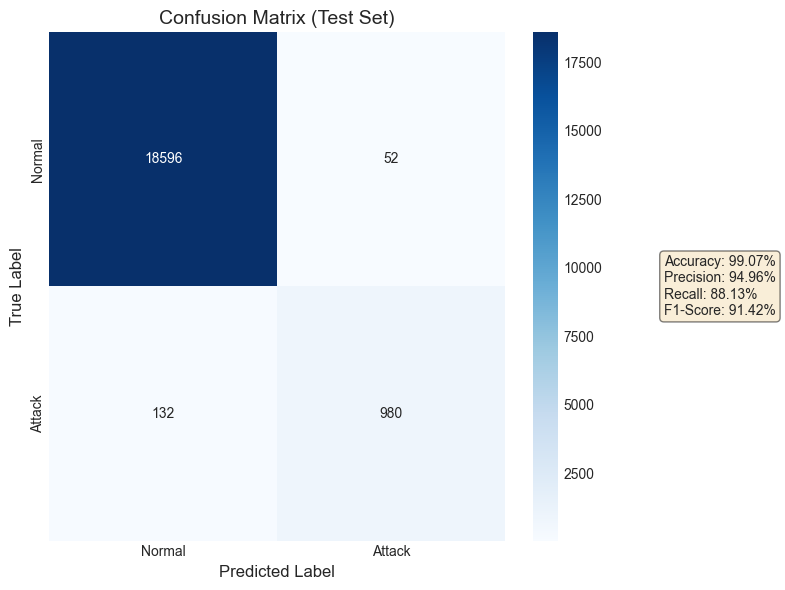

✓ 混淆矩阵已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\confusion_matrix_test.png


In [15]:
# 5.1 混淆矩阵热力图
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix (Test Set)', fontsize=14)

# 添加性能指标标注
textstr = f'Accuracy: {test_metrics["accuracy"]*100:.2f}%\n'
textstr += f'Precision: {test_metrics["precision"]*100:.2f}%\n'
textstr += f'Recall: {test_metrics["recall"]*100:.2f}%\n'
textstr += f'F1-Score: {test_metrics["f1"]*100:.2f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrix_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 混淆矩阵已保存: {FIGURES_DIR / 'confusion_matrix_test.png'}")

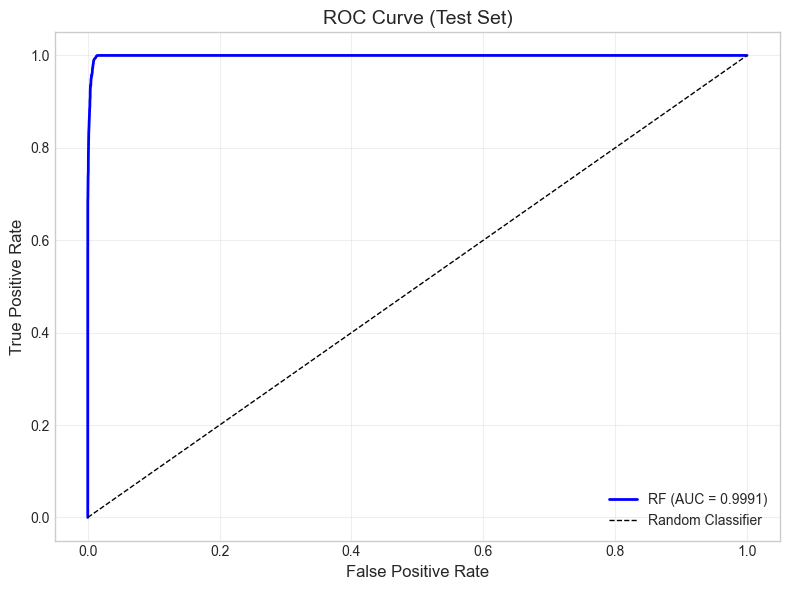

✓ ROC曲线已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\roc_curve.png


In [16]:
# 5.2 ROC曲线
# 将标签转换为二进制
y_test_binary = (y_test == 'Attack').astype(int)
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, 'b-', linewidth=2, 
        label=f'RF (AUC = {test_metrics["auc_roc"]:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve (Test Set)', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ ROC曲线已保存: {FIGURES_DIR / 'roc_curve.png'}")

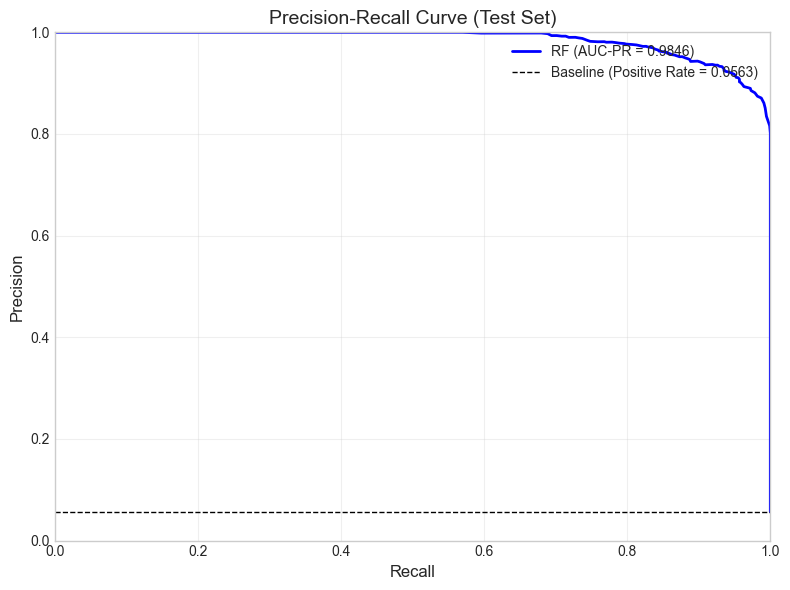

✓ PR曲线已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\pr_curve.png


In [17]:
# 5.3 PR曲线（不平衡数据关键指标）
precision_curve, recall_curve, _ = precision_recall_curve(y_test_binary, y_pred_proba)

# 计算基线（随机分类器）
baseline = y_test_binary.sum() / len(y_test_binary)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(recall_curve, precision_curve, 'b-', linewidth=2,
        label=f'RF (AUC-PR = {test_metrics["auc_pr"]:.4f})')
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1,
           label=f'Baseline (Positive Rate = {baseline:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve (Test Set)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ PR曲线已保存: {FIGURES_DIR / 'pr_curve.png'}")

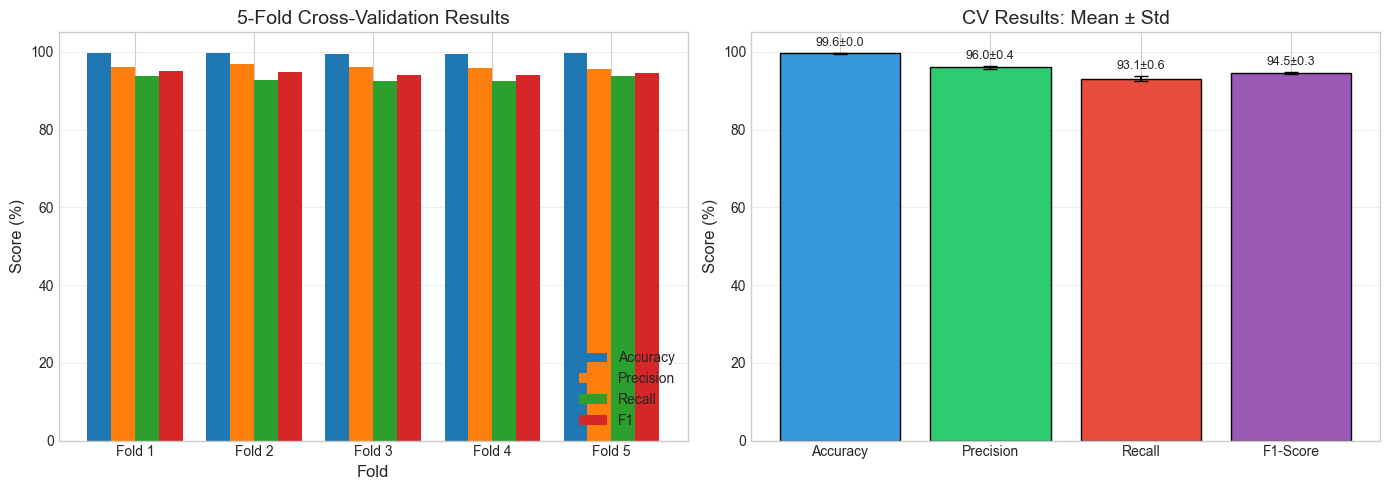

✓ CV对比图已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\cv_fold_comparison.png


In [18]:
# 5.4 5-fold交叉验证性能对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：各折指标对比
metrics_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(N_FOLDS)
width = 0.2

for i, metric in enumerate(metrics_plot):
    values = cv_df[metric].values * 100
    axes[0].bar(x + i*width, values, width, label=metric.capitalize())

axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Score (%)', fontsize=12)
axes[0].set_title('5-Fold Cross-Validation Results', fontsize=14)
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)])
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 105])
axes[0].grid(True, alpha=0.3, axis='y')

# 右图：均值±标准差
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = [cv_summary[m]['mean']*100 for m in metrics_plot]
stds = [cv_summary[m]['std']*100 for m in metrics_plot]

bars = axes[1].bar(metrics_names, means, yerr=stds, capsize=5,
                   color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
                   edgecolor='black', linewidth=1)

axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('CV Results: Mean ± Std', fontsize=14)
axes[1].set_ylim([0, 105])
axes[1].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar, mean, std in zip(bars, means, stds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 1,
                 f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cv_fold_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ CV对比图已保存: {FIGURES_DIR / 'cv_fold_comparison.png'}")

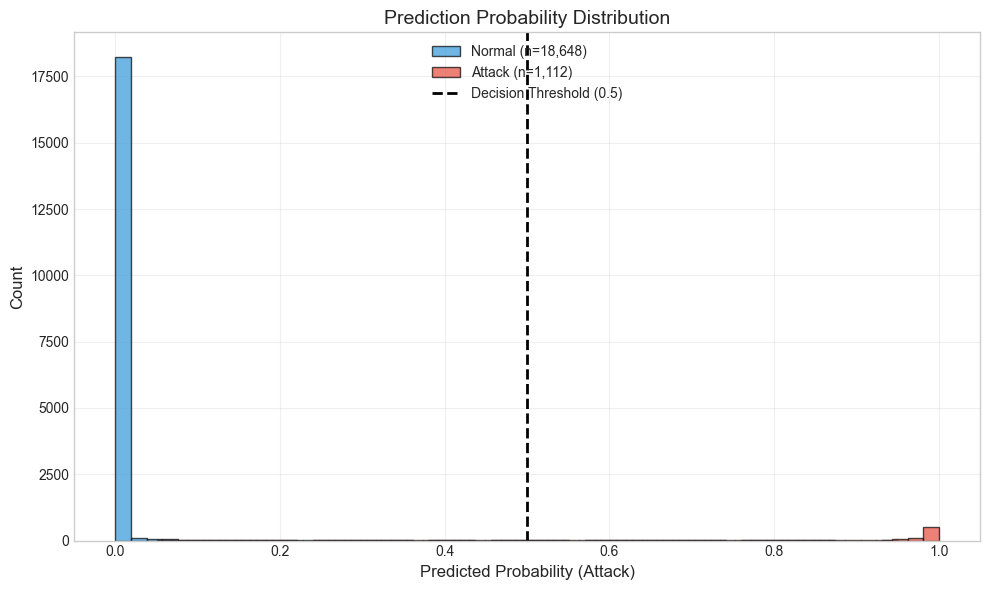

✓ 概率分布图已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\probability_distribution.png


In [19]:
# 5.5 预测概率分布（附加）
fig, ax = plt.subplots(figsize=(10, 6))

# 分离Normal和Attack的预测概率
proba_normal = y_pred_proba[y_test == 'Normal']
proba_attack = y_pred_proba[y_test == 'Attack']

ax.hist(proba_normal, bins=50, alpha=0.7, label=f'Normal (n={len(proba_normal):,})',
        color='#3498db', edgecolor='black')
ax.hist(proba_attack, bins=50, alpha=0.7, label=f'Attack (n={len(proba_attack):,})',
        color='#e74c3c', edgecolor='black')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

ax.set_xlabel('Predicted Probability (Attack)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Prediction Probability Distribution', fontsize=14)
ax.legend(loc='upper center', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'probability_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 概率分布图已保存: {FIGURES_DIR / 'probability_distribution.png'}")

## 6. 特征重要性预览

In [20]:
# 特征重要性预览（详细分析在Phase 4）
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("特征重要性 Top 15 (预览)")
print("="*60)
print(feature_importance.head(15).to_string(index=False))


特征重要性 Top 15 (预览)
                   feature  importance
             fc_read_ratio    0.154155
            fc_write_ratio    0.122073
     consecutive_write_max    0.114132
    consecutive_write_mean    0.109341
              fc_diversity    0.097492
operation_sequence_entropy    0.093253
    read_write_alternation    0.092064
          packet_size_mean    0.057078
           packet_size_std    0.025643
   fc_distribution_entropy    0.025010
           burst_intensity    0.020670
                  txid_std    0.015767
              interval_min    0.012073
              interval_std    0.009902
             interval_mean    0.008798


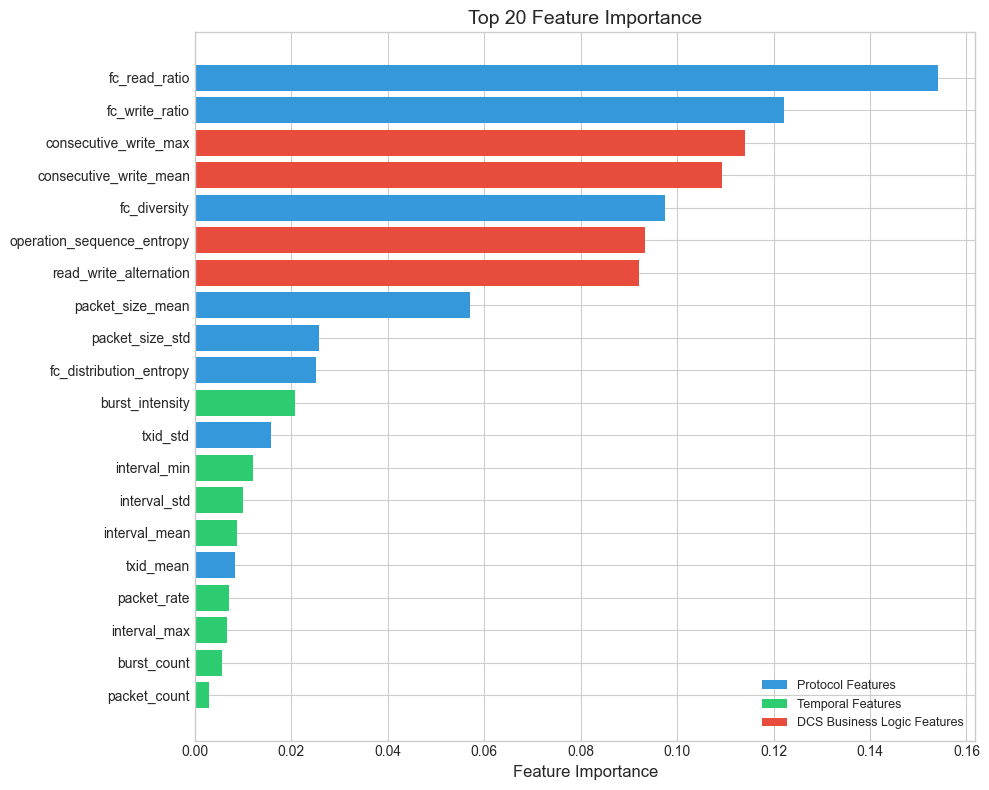

✓ 特征重要性图已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\feature_importance_preview.png


In [21]:
# 特征重要性可视化 (Top 20)
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 20
top_features = feature_importance.head(top_n)

# 获取特征分组信息
feature_groups = get_feature_groups()

# 为不同类型特征着色
colors = []
for feat in top_features['feature']:
    if feat in feature_groups['protocol']:
        colors.append('#3498db')  # 蓝色 - 协议层
    elif feat in feature_groups['temporal']:
        colors.append('#2ecc71')  # 绿色 - 时序层
    else:
        colors.append('#e74c3c')  # 红色 - DCS业务逻辑

bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()

ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importance', fontsize=14)

# 添加图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Protocol Features'),
    Patch(facecolor='#2ecc71', label='Temporal Features'),
    Patch(facecolor='#e74c3c', label='DCS Business Logic Features')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_importance_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 特征重要性图已保存: {FIGURES_DIR / 'feature_importance_preview.png'}")

In [22]:
# 按特征类别汇总重要性
print("\n特征类别重要性汇总:")

category_importance = {}
for category, features in feature_groups.items():
    mask = feature_importance['feature'].isin(features)
    total_importance = feature_importance[mask]['importance'].sum()
    category_importance[category] = total_importance

# 合并DCS子类别
dcs_total = sum(v for k, v in category_importance.items() if k.startswith('dcs_'))

print(f"\n  协议层特征:      {category_importance['protocol']*100:.2f}%")
print(f"  时序层特征:      {category_importance['temporal']*100:.2f}%")
print(f"  DCS业务逻辑特征: {dcs_total*100:.2f}%  ← 核心创新点")
print(f"    - 设备角色:    {category_importance['dcs_device_role']*100:.2f}%")
print(f"    - 通信拓扑:    {category_importance['dcs_topology']*100:.2f}%")
print(f"    - 操作模式:    {category_importance['dcs_operation']*100:.2f}%")
print(f"    - 异常指标:    {category_importance['dcs_anomaly']*100:.2f}%")


特征类别重要性汇总:

  协议层特征:      50.70%
  时序层特征:      7.41%
  DCS业务逻辑特征: 41.88%  ← 核心创新点
    - 设备角色:    0.35%
    - 通信拓扑:    0.51%
    - 操作模式:    41.02%
    - 异常指标:    0.01%


## 7. 模型保存

In [23]:
# 保存模型
model_path = MODELS_DIR / 'rf_baseline.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

# 获取模型大小
model_size_bytes = os.path.getsize(model_path)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"\n模型已保存: {model_path}")
print(f"模型大小: {model_size_mb:.2f} MB")


模型已保存: c:\Users\Echo\Desktop\modbus-detection\models\rf_baseline.pkl
模型大小: 9.93 MB


In [24]:
# 保存模型元信息
metadata = {
    'created_at': datetime.now().isoformat(),
    'model_type': 'RandomForestClassifier',
    'params': RF_PARAMS,
    'training': {
        'samples': len(X_train),
        'features': len(feature_names),
        'train_time_seconds': train_time,
        'oob_score': rf_model.oob_score_
    },
    'test_performance': {
        'samples': len(X_test),
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'auc_roc': test_metrics['auc_roc'],
        'auc_pr': test_metrics['auc_pr'],
        'confusion_matrix': cm.tolist(),
        'inference_time_ms_per_sample': inference_time_per_sample
    },
    'cv_performance': {
        'n_folds': N_FOLDS,
        'accuracy': {'mean': cv_summary['accuracy']['mean'], 'std': cv_summary['accuracy']['std']},
        'precision': {'mean': cv_summary['precision']['mean'], 'std': cv_summary['precision']['std']},
        'recall': {'mean': cv_summary['recall']['mean'], 'std': cv_summary['recall']['std']},
        'f1': {'mean': cv_summary['f1']['mean'], 'std': cv_summary['f1']['std']},
        'auc_roc': {'mean': cv_summary['auc_roc']['mean'], 'std': cv_summary['auc_roc']['std']},
        'auc_pr': {'mean': cv_summary['auc_pr']['mean'], 'std': cv_summary['auc_pr']['std']}
    },
    'model_size_mb': model_size_mb,
    'feature_names': feature_names
}

metadata_path = MODELS_DIR / 'rf_baseline_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"模型元信息已保存: {metadata_path}")

模型元信息已保存: c:\Users\Echo\Desktop\modbus-detection\models\rf_baseline_metadata.json


In [25]:
# 保存结果表格

# 1. 测试集指标
test_metrics_df = pd.DataFrame([{
    'dataset': 'test',
    'samples': len(X_test),
    'accuracy': test_metrics['accuracy'],
    'precision': test_metrics['precision'],
    'recall': test_metrics['recall'],
    'f1': test_metrics['f1'],
    'auc_roc': test_metrics['auc_roc'],
    'auc_pr': test_metrics['auc_pr']
}])
test_metrics_df.to_csv(TABLES_DIR / 'phase2_test_metrics.csv', index=False)

# 2. 交叉验证结果
cv_df.to_csv(TABLES_DIR / 'phase2_cv_results.csv', index=False)

# 3. 特征重要性
feature_importance.to_csv(TABLES_DIR / 'phase2_feature_importance.csv', index=False)

print(f"\n结果表格已保存:")
print(f"  - {TABLES_DIR / 'phase2_test_metrics.csv'}")
print(f"  - {TABLES_DIR / 'phase2_cv_results.csv'}")
print(f"  - {TABLES_DIR / 'phase2_feature_importance.csv'}")


结果表格已保存:
  - c:\Users\Echo\Desktop\modbus-detection\results\tables\phase2_test_metrics.csv
  - c:\Users\Echo\Desktop\modbus-detection\results\tables\phase2_cv_results.csv
  - c:\Users\Echo\Desktop\modbus-detection\results\tables\phase2_feature_importance.csv


## 8. 结果汇总

In [26]:
print("\n" + "="*70)
print("                    Phase 2 实验结果汇总")
print("="*70)

print("\n【数据集】")
print(f"  训练集: {len(X_train):,} 样本 (Attack: {(y_train=='Attack').sum():,}, {(y_train=='Attack').mean()*100:.2f}%)")
print(f"  测试集: {len(X_test):,} 样本 (Attack: {(y_test=='Attack').sum():,}, {(y_test=='Attack').mean()*100:.2f}%)")
print(f"  特征数: {len(feature_names)}")

print("\n【测试集性能】")
print(f"  Accuracy:  {test_metrics['accuracy']*100:.2f}%")
print(f"  Precision: {test_metrics['precision']*100:.2f}%")
print(f"  Recall:    {test_metrics['recall']*100:.2f}%  ← 攻击检测召回率")
print(f"  F1-Score:  {test_metrics['f1']*100:.2f}%")
print(f"  AUC-ROC:   {test_metrics['auc_roc']:.4f}")
print(f"  AUC-PR:    {test_metrics['auc_pr']:.4f}")

print("\n【5-Fold 交叉验证】")
print(f"  Accuracy:  {cv_summary['accuracy']['mean']*100:.2f}% ± {cv_summary['accuracy']['std']*100:.2f}%")
print(f"  Precision: {cv_summary['precision']['mean']*100:.2f}% ± {cv_summary['precision']['std']*100:.2f}%")
print(f"  Recall:    {cv_summary['recall']['mean']*100:.2f}% ± {cv_summary['recall']['std']*100:.2f}%")
print(f"  F1-Score:  {cv_summary['f1']['mean']*100:.2f}% ± {cv_summary['f1']['std']*100:.2f}%")

print("\n【轻量级指标】")
print(f"  训练时间:     {train_time:.2f} 秒")
print(f"  推理时间:     {inference_time_per_sample:.4f} ms/样本")
print(f"  模型大小:     {model_size_mb:.2f} MB")

print("\n【预期目标达成情况】")
targets = [
    ("Accuracy > 95%", test_metrics['accuracy'] > 0.95),
    ("F1-Score > 90%", test_metrics['f1'] > 0.90),
    ("推理时间 < 10ms", inference_time_per_sample < 10)
]
for desc, achieved in targets:
    status = "✓ 达成" if achieved else "✗ 未达成"
    print(f"  {desc}: {status}")

print("\n【输出文件】")
print(f"  模型: {model_path}")
print(f"  元信息: {metadata_path}")
print(f"  图表: {FIGURES_DIR}")
print(f"  表格: {TABLES_DIR}")

print("\n" + "="*70)
print("                    Phase 2 实验完成!")
print("="*70)


                    Phase 2 实验结果汇总

【数据集】
  训练集: 83,078 样本 (Attack: 3,346, 4.03%)
  测试集: 19,760 样本 (Attack: 1,112, 5.63%)
  特征数: 44

【测试集性能】
  Accuracy:  99.07%
  Precision: 94.96%
  Recall:    88.13%  ← 攻击检测召回率
  F1-Score:  91.42%
  AUC-ROC:   0.9991
  AUC-PR:    0.9846

【5-Fold 交叉验证】
  Accuracy:  99.57% ± 0.02%
  Precision: 96.02% ± 0.38%
  Recall:    93.07% ± 0.61%
  F1-Score:  94.52% ± 0.32%

【轻量级指标】
  训练时间:     3.68 秒
  推理时间:     0.0043 ms/样本
  模型大小:     9.93 MB

【预期目标达成情况】
  Accuracy > 95%: ✓ 达成
  F1-Score > 90%: ✓ 达成
  推理时间 < 10ms: ✓ 达成

【输出文件】
  模型: c:\Users\Echo\Desktop\modbus-detection\models\rf_baseline.pkl
  元信息: c:\Users\Echo\Desktop\modbus-detection\models\rf_baseline_metadata.json
  图表: c:\Users\Echo\Desktop\modbus-detection\results\figures
  表格: c:\Users\Echo\Desktop\modbus-detection\results\tables

                    Phase 2 实验完成!


---

## 下一步: Phase 3

Phase 2 完成后，下一阶段将进行:

1. **E3: 算法对比** - RF vs DT vs LR vs XGBoost vs MLP
2. **E4: 架构对比** - 纯规则 vs 纯ML vs 两层架构
3. **E6: DCS业务逻辑特征消融实验** - 验证核心创新点